In [17]:
from astropy.table import Table
from astropy.io import ascii, fits
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from matplotlib.patches import Circle, Ellipse, Rectangle
from radio_beam import Beam

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
import astropy.constants as const

from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path, PathFromCenter

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

In [18]:
fl = '/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/NGC1266_NIFS_final_trim_wcs2.fits'
cube = SpectralCube.read(fl, hdu=1)
cube_head = cube.header
cube_wcs = cube.wcs.celestial

maps_path = '/Users/jotter/highres_PSBs/ngc1266_NIFS/fit_output/c3_run4_gaussfit_maps.fits'
maps_fl = fits.open(maps_path)
maps = maps_fl[0].data
maps_wcs = WCS(maps_fl[0].header).celestial
maps_head = maps_fl[0].header
maps_fl.close()

H2_10_S2_flux = maps[8,:,:]
H2_10_S2_mask = maps[10,:,:]
H2_10_S2_bool = np.where(H2_10_S2_mask == 1, True, False)
H2_10_S2_flux_det = H2_10_S2_flux.copy()
H2_10_S2_flux_det[H2_10_S2_bool == False] = np.nan

H2_10_S1_flux = maps[11,:,:]
H2_10_S1_mask = maps[13,:,:]
H2_10_S1_bool = np.where(H2_10_S1_mask == 1, True, False)
H2_10_S1_flux_det = H2_10_S1_flux.copy()
H2_10_S1_flux_det[H2_10_S1_bool == False] = np.nan

H2_10_S0_flux = maps[14,:,:]
H2_10_S0_mask = maps[16,:,:]
H2_10_S0_bool = np.where(H2_10_S0_mask == 1, True, False)
H2_10_S0_flux_det = H2_10_S0_flux.copy()
H2_10_S0_flux_det[H2_10_S0_bool == False] = np.nan

H2_21_S1_flux = maps[17,:,:]
H2_21_S1_mask = maps[19,:,:]
H2_21_S1_bool = np.where(H2_21_S1_mask == 1, True, False)
H2_21_S1_flux_det = H2_21_S1_flux.copy()
H2_21_S1_flux_det[H2_21_S1_bool == False] = np.nan

H2_21_S2_flux = maps[20,:,:]
H2_21_S2_mask = maps[22,:,:]
H2_21_S2_bool = np.where(H2_21_S2_mask == 1, True, False)
H2_21_S2_flux_det = H2_21_S2_flux.copy()
H2_21_S2_flux_det[H2_21_S2_bool == False] = np.nan

brgamma_flux = maps[23,:,:]
brgamma_mask = maps[25,:,:]
brgamma_bool = np.where(brgamma_mask == 1, True, False)
brgamma_flux_det = brgamma_flux.copy()
brgamma_flux_det[brgamma_bool == False] = np.nan

H2_21_S3_flux = maps[26,:,:]
H2_10_Q1_flux = maps[29,:,:]


vel1 = maps[0,:,:]
vel1[H2_10_S1_bool == False] = np.nan

vel1 = vel1 - np.nanmedian(vel1)

vel2 = maps[2,:,:]
vel2[H2_10_S1_bool == False] = np.nan
sigma1 = maps[4,:,:]
sigma1[H2_10_S1_bool == False] = np.nan
sigma2 = maps[6,:,:]
sigma2[H2_10_S1_bool == False] = np.nan


In [19]:
##defining apertures

#galaxy center aperture:
gal_cen = SkyCoord(ra='3:16:00.74576', dec='-2:25:38.70151', unit=(u.hourangle, u.degree),
                   frame='icrs') #from HST H band image, by eye
gal_cen_pix = cube.wcs.celestial.all_world2pix(gal_cen.ra, gal_cen.dec, 0)

ap1_cen_pix = [22,42]

ap2_cen_pix = [62,22]

radius_pc = 50*u.pc
z = 0.007214
D_L = cosmo.luminosity_distance(z).to(u.Mpc)
as_per_kpc = cosmo.arcsec_per_kpc_comoving(z)

radius_as = (radius_pc * as_per_kpc).decompose()
radius_pix = (radius_as / (0.043*u.arcsecond)).decompose()

as_to_pix = 1 / (0.043*u.arcsecond)

In [20]:
##loading in CO data

co_path = '/Users/jotter/highres_PSBs/ngc1266_data/ngc1266_co.fits'
co_cube = SpectralCube.read(co_path)

co_freq = 115.3 * u.GHz
co_freq_obs = co_freq / (1+z)
co_cube_kms = co_cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=co_freq_obs)
co_slab = co_cube_kms.spectral_slab(-600*u.km/u.s, 600*u.km/u.s)

co_wcs = co_cube_kms.wcs.celestial

co_mom0 = co_slab.moment(0)

co_beam = Beam.from_fits_header(co_cube.header)

co_pix_size = co_cube.header['CDELT2']
beam_area = co_beam.major * co_beam.minor * 2*np.pi/(8*np.log(2)) #degrees**2
beam_area_per_pix = beam_area / ((co_pix_size * u.degree)**2)

print(beam_area_per_pix)

co_mom0 = co_mom0/beam_area_per_pix

124.12990410270578


In [21]:
##loading in VLA data
vla_fl = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/VLA/NGC1266_Cband_Aconfig_subim.fits')

vla_data = vla_fl[0].data.squeeze()
vla_header = vla_fl[0].header

vla_fl.close()

vla_wcs = WCS(vla_header).celestial

vla_beam = Beam.from_fits_header(vla_header)
vla_pix_size = vla_header['CDELT2'] * u.degree


/var/folders/vf/84glvj217td2j5kktzkvgpqr0000gn/T/ipykernel_22014/929823456.py:18: RuntimeWarning: divide by zero encountered in log10
  log_mom0 = np.log10(mom0.value)
/var/folders/vf/84glvj217td2j5kktzkvgpqr0000gn/T/ipykernel_22014/929823456.py:18: RuntimeWarning: invalid value encountered in log10
  log_mom0 = np.log10(mom0.value)


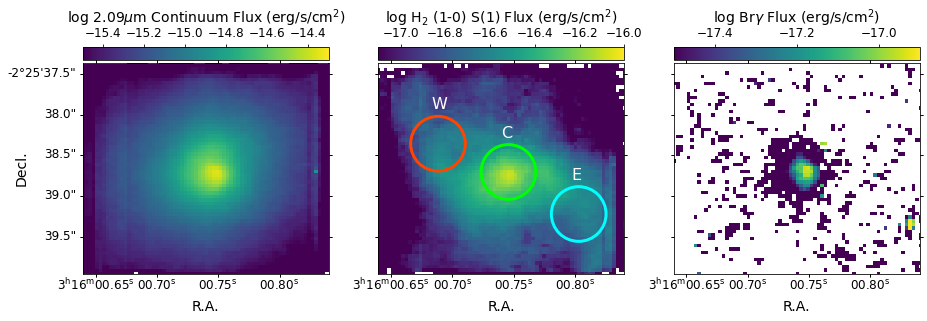

In [24]:
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 3, wspace=0.2)

gal_cen_p = Circle(gal_cen_pix, radius=radius_pix, fill=None, edgecolor='lime', linewidth=3)
ap1_cen_p = Circle(ap1_cen_pix, radius=radius_pix, fill=None, edgecolor='orangered', linewidth=3)
ap2_cen_p = Circle(ap2_cen_pix, radius=radius_pix, fill=None, edgecolor='cyan', linewidth=3)

gal_cen_size_p = Circle(gal_cen_pix, radius=radius_pix/2, fill=None, edgecolor='tab:red')


##AX0
ax0 = fig.add_subplot(gs[0,0], projection=cube.wcs.celestial)

cont_lambda = 2.09 * u.micron
cube_cont_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=cont_lambda)
slab_cont = cube_cont_kms.spectral_slab(-600*u.km/u.s, 600*u.km/u.s)
mom0 = slab_cont.moment(order=0)
log_mom0 = np.log10(mom0.value)

cont_mappable = ax0.imshow(log_mom0, vmin=-15.5, vmax=-14.3)#, transform=ax0.get_transform(cube_wcs))

cbar0 = fig.colorbar(cont_mappable, ax=ax0, orientation='horizontal', location='top', pad=0.01)
cbar0.ax.tick_params(labelsize=12)

ax0.tick_params(labelsize=12)
ax0.set_ylabel('Decl.', fontsize=14, labelpad=-1)
ax0.set_xlabel('R.A.', fontsize=14)
ax0.set_title(r'log 2.09$\mu$m Continuum Flux (erg/s/cm$^2$)', fontsize=14, pad=40)

#ax0.add_patch(gal_cen_p)
#ax0.add_patch(ap1_cen_p)
#ax0.add_patch(ap2_cen_p)

ax0.set_xlim(5,75)
ax0.set_ylim(5,65)

## AX1
ax1 = fig.add_subplot(gs[0,1], projection=cube_wcs, sharex=ax0, sharey=ax0)

log_H2_10_S1_flux_det = np.log10(H2_10_S1_flux_det)
h2_mappable = ax1.imshow(log_H2_10_S1_flux_det, vmin=-17.1, vmax=-16, transform=ax1.get_transform(cube_wcs))

cbar1 = fig.colorbar(h2_mappable, ax=ax1, orientation='horizontal', location='top', pad=0.01)
cbar1.ax.tick_params(labelsize=12)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelleft=False)
ax1.set_ylabel(' ')
ax1.set_xlabel('R.A.', fontsize=14)
ax1.set_title(r'log H$_2$ (1-0) S(1) Flux (erg/s/cm$^2$)', fontsize=14, pad=40)

#ax1.set_xlim(5,78)
#ax1.set_ylim(5,65)

ax1.add_patch(gal_cen_p)
ax1.add_patch(ap1_cen_p)
ax1.add_patch(ap2_cen_p)

#ax1.contour(vla_data, levels=vla_levels, transform=ax1.get_transform(vla_wcs), colors='lime')
beam_xy = [15,15]
major_pix = (vla_beam.major * as_to_pix).decompose()
minor_pix = (vla_beam.minor * as_to_pix).decompose()
beam_ellipse = Ellipse(beam_xy, major_pix.value, minor_pix.value, co_beam.pa.value, alpha=0.4, ec='k', fc='lime')

#ax1.add_patch(beam_ellipse)

ax1.text(ap1_cen_pix[0]-2, ap1_cen_pix[1]+radius_pix+2, 'W', fontsize=16, color='white')
ax1.text(ap2_cen_pix[0]-2, ap2_cen_pix[1]+radius_pix+2, 'E', fontsize=16, color='white')
ax1.text(gal_cen_pix[0]-2, gal_cen_pix[1]+radius_pix+2, 'C', fontsize=16, color='white')


##AX2
ax2 = fig.add_subplot(gs[0,2], projection=cube_wcs, sharex=ax0, sharey=ax0)

log_brgamma_flux_det = np.log10(brgamma_flux_det)
brgamma_mappable = ax2.imshow(log_brgamma_flux_det, vmin=-17.5, vmax=-16.9, transform=ax2.get_transform(cube_wcs))

cbar2 = fig.colorbar(brgamma_mappable, ax=ax2, orientation='horizontal', location='top', pad=0.01)
cbar2.ax.tick_params(labelsize=12)

#ax2.contour(co_mom0, colors='tab:red', transform=ax2.get_transform(co_wcs))

#ax2.set_xlim(5,78)
#ax2.set_ylim(5,65)

#ax2.add_patch(gal_cen_size_p)

beam_xy = [18,18]
major_pix = (co_beam.major * as_to_pix).decompose()
minor_pix = (co_beam.minor * as_to_pix).decompose()
beam_ellipse = Ellipse(beam_xy, major_pix.value, minor_pix.value, co_beam.pa.value, alpha=0.4, ec='k', fc='tab:red')

#ax2.add_patch(beam_ellipse)

ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelleft=False)
ax2.set_ylabel(' ')
ax2.set_xlabel('R.A.', fontsize=14)
ax2.set_title(r'log Br$\gamma$ Flux (erg/s/cm$^2$)', fontsize=14, pad=40)

#ax2.add_patch(gal_cen_p)

plt.savefig('plots/flux_maps.pdf', dpi=500, bbox_inches='tight')

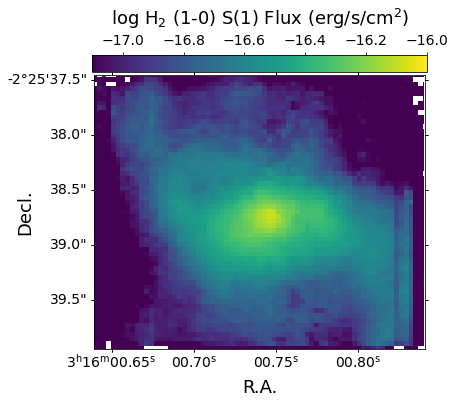

In [7]:
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(1, 1, wspace=0.2)

gal_cen_p = Circle(gal_cen_pix, radius=radius_pix, fill=None, edgecolor='lime', linewidth=3)
ap1_cen_p = Circle(ap1_cen_pix, radius=radius_pix, fill=None, edgecolor='orangered', linewidth=3)
ap2_cen_p = Circle(ap2_cen_pix, radius=radius_pix, fill=None, edgecolor='cyan', linewidth=3)

gal_cen_size_p = Circle(gal_cen_pix, radius=radius_pix/2, fill=None, edgecolor='tab:red')

ax1 = fig.add_subplot(gs[0,0], projection=cube_wcs)

log_H2_10_S1_flux_det = np.log10(H2_10_S1_flux_det)
h2_mappable = ax1.imshow(log_H2_10_S1_flux_det, vmin=-17.1, vmax=-16, transform=ax1.get_transform(cube_wcs))

cbar1 = fig.colorbar(h2_mappable, ax=ax1, orientation='horizontal', location='top', pad=0.01)
cbar1.ax.tick_params(labelsize=14)

ax1.tick_params(labelsize=14)
ax1.set_ylabel('Decl.', fontsize=18, labelpad=-1)
ax1.set_xlabel('R.A.', fontsize=18)
ax1.set_title(r'log H$_2$ (1-0) S(1) Flux (erg/s/cm$^2$)', fontsize=18, pad=50)

#ax1.add_patch(gal_cen_p)
#ax1.add_patch(ap1_cen_p)
#ax1.add_patch(ap2_cen_p)

#ax1.text(ap1_cen_pix[0]-2, ap1_cen_pix[1]+radius_pix-3, 'A', fontsize=16, color='white')
#ax1.text(ap2_cen_pix[0]-2, ap2_cen_pix[1]+radius_pix-3, 'B', fontsize=16, color='white')
#ax1.text(gal_cen_pix[0]-2, gal_cen_pix[1]+radius_pix-3, 'C', fontsize=16, color='white')

ax1.set_xlim(5,75)
ax1.set_ylim(5,63)

#ax1.contour(vla_data, levels=vla_levels, transform=ax1.get_transform(vla_wcs), colors='lime')
beam_xy = [15,15]
major_pix = (vla_beam.major * as_to_pix).decompose()
minor_pix = (vla_beam.minor * as_to_pix).decompose()
beam_ellipse = Ellipse(beam_xy, major_pix.value, minor_pix.value, co_beam.pa.value, alpha=0.4, ec='k', fc='lime')

#ax1.add_patch(beam_ellipse)

#plt.savefig('plots/H2_flux_map_noap.png', dpi=500, bbox_inches='tight')

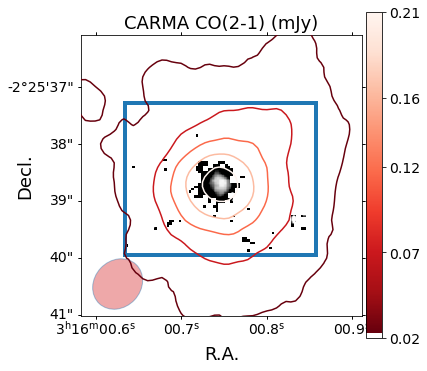

In [23]:
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(1, 1, wspace=0.2)

gal_cen_p = Circle(gal_cen_pix, radius=radius_pix, fill=None, edgecolor='tab:red')
ap1_cen_p = Circle(ap1_cen_pix, radius=radius_pix, fill=None, edgecolor='tab:red')
ap2_cen_p = Circle(ap2_cen_pix, radius=radius_pix, fill=None, edgecolor='tab:red')

gal_cen_size_p = Circle(gal_cen_pix, radius=radius_pix/2, fill=None, edgecolor='tab:red')

ax2 = fig.add_subplot(gs[0,0], projection=maps_wcs)

log_brgamma_flux_det = np.log10(brgamma_flux_det)
brgamma_mappable = ax2.imshow(log_brgamma_flux_det, vmin=-17.5, vmax=-16.9, transform=ax2.get_transform(cube_wcs), cmap='Greys_r')

co_levels = np.nanmax(co_mom0) * np.array([0.1, 0.3, 0.5, 0.7, 0.9])

co_mappable = ax2.contour(co_mom0, cmap='Reds_r', transform=ax2.get_transform(co_wcs), levels=co_levels)
#cbar3 = fig.colorbar(co_mappable, ax=ax2, orientation='vertical', location='right', pad=0.1)

#ax2.set_xlim(5,78)
#ax2.set_ylim(5,65)

ax2.set_xlim(-15,100)
ax2.set_ylim(-20,95)

norm = mpl.colors.Normalize(vmin=co_levels[0].value, vmax=co_levels[-1].value)
mappable_cont = mpl.cm.ScalarMappable(norm=norm, cmap='Reds_r')

cbar2 = fig.colorbar(mappable_cont, ax=ax2, orientation='vertical', location='right', pad=0.01)
cbar2.ax.tick_params(labelsize=14)
cbar2.ax.set_yticks(np.round(co_levels.value, 2))

#ax2.add_patch(gal_cen_size_p)

beam_xy = [0,-7]
major_pix = (co_beam.major * as_to_pix).decompose()
minor_pix = (co_beam.minor * as_to_pix).decompose()
beam_ellipse = Ellipse(beam_xy, major_pix.value, minor_pix.value, co_beam.pa.value, alpha=0.4, ec='tab:blue', fc='tab:red')

ax2.add_patch(beam_ellipse)

ax2.tick_params(labelsize=14)
ax2.set_ylabel('Decl.', fontsize=18, labelpad=-1)
ax2.set_xlabel('R.A.', fontsize=18)
ax2.set_title(r'CARMA CO(2-1) (mJy)', fontsize=18)

fov_rect = Rectangle((3,5), 78, 62, fill=None, ec='tab:blue', lw=4)
ax2.add_patch(fov_rect)

plt.savefig('plots/Brgamma_CO_flux_map.pdf', dpi=500, bbox_inches='tight')

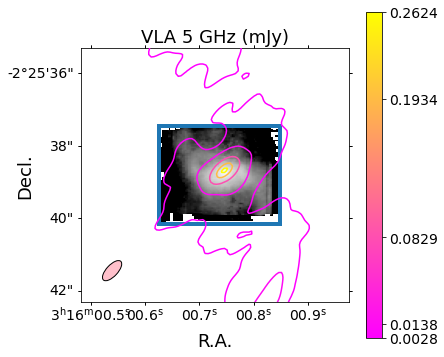

In [6]:
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(1, 1, wspace=0.2)

gal_cen_p = Circle(gal_cen_pix, radius=radius_pix, fill=None, edgecolor='lime', linewidth=3)
ap1_cen_p = Circle(ap1_cen_pix, radius=radius_pix, fill=None, edgecolor='orangered', linewidth=3)
ap2_cen_p = Circle(ap2_cen_pix, radius=radius_pix, fill=None, edgecolor='cyan', linewidth=3)

gal_cen_size_p = Circle(gal_cen_pix, radius=radius_pix/2, fill=None, edgecolor='tab:red')

ax1 = fig.add_subplot(gs[0,0], projection=cube_wcs)

log_H2_10_S1_flux_det = np.log10(H2_10_S1_flux_det)
h2_mappable = ax1.imshow(log_H2_10_S1_flux_det, vmin=-17.1, vmax=-16, transform=ax1.get_transform(cube_wcs), cmap='Greys_r')

#cax1 = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
#cbar1 = fig.colorbar(h2_mappable, ax=cax, orientation='horizontal', location='top', pad=0.01)
#cbar1.ax.tick_params(labelsize=14)

ax1.tick_params(labelsize=14)
ax1.set_ylabel('Decl.', fontsize=18, labelpad=-1)
ax1.set_xlabel('R.A.', fontsize=18)
ax1.set_title(r'VLA 5 GHz (mJy)', fontsize=18)

ax1.set_xlim(-50, 122)
ax1.set_ylim(-50,113)
#ax1.set_xlim(-100, 172)
#ax1.set_ylim(-100,163)


ppbeam = vla_beam.sr / ((vla_pix_size)**2)
vla_data_mjy = (vla_data / ppbeam * 1000).decompose()

#vla_levels = np.array([1,3,10,50,136]) * 0.07*1e-3
vla_levels = np.nanmax(vla_data_mjy) * np.array([0.01, 0.05, 0.3, 0.7, 0.95])

vla_mappable = ax1.contour(vla_data_mjy, levels=vla_levels, transform=ax1.get_transform(vla_wcs), cmap='spring')

norm = mpl.colors.Normalize(vmin=vla_levels[0], vmax=vla_levels[-1])
mappable_cont = mpl.cm.ScalarMappable(norm=norm, cmap='spring')

cbar2 = fig.colorbar(mappable_cont, ax=ax1, orientation='vertical', location='right', pad=0.05)
cbar2.ax.tick_params(labelsize=14)
cbar2.ax.set_yticks(vla_levels)


beam_xy = [-30, -30]
major_pix = (vla_beam.major * as_to_pix).decompose()
minor_pix = (vla_beam.minor * as_to_pix).decompose()
beam_ellipse = Ellipse(beam_xy, major_pix.value, minor_pix.value, co_beam.pa.value,  ec='k', fc='pink')

ax1.add_patch(beam_ellipse)

fov_rect = Rectangle((0,0), 78, 63, fill=None, ec='tab:blue', lw=4)
ax1.add_patch(fov_rect)

plt.savefig('plots/VLA_contour_H2_map.pdf', dpi=500, bbox_inches='tight')

## line ratio maps

(5.0, 63.0)

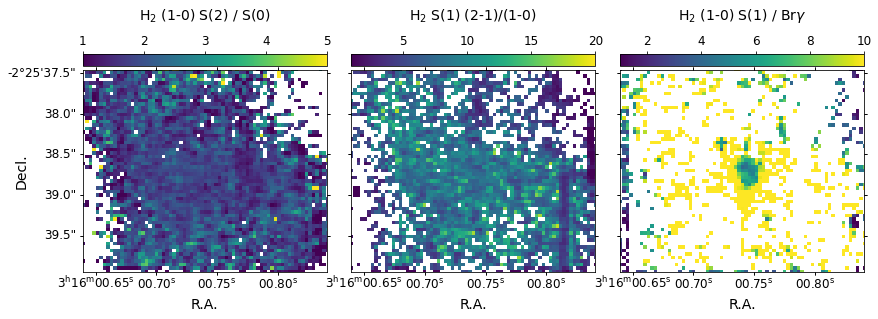

In [8]:
#ax1: H2 (1-0) S(2)/S(0)
#ax2: H2 (2-1)/(1-0) S(1) 
#ax3: H2 (1-0) S(1)/ Brgamma


H2_S2S0 = H2_10_S2_flux_det / H2_10_S0_flux_det
H2_1021_S1 = H2_10_S1_flux_det / H2_21_S1_flux_det
H2_brgamma = H2_10_S1_flux_det / brgamma_flux_det


fig = plt.figure(figsize=(14, 6))
gs = GridSpec(1, 3, wspace=0.1)


ax1 = fig.add_subplot(gs[0,0], projection=cube_wcs)

H2_S2S0 = H2_10_S2_flux_det / H2_10_S0_flux_det


h2_mappable = ax1.imshow(H2_S2S0, transform=ax1.get_transform(cube_wcs), vmin=1, vmax=5)

cbar1 = fig.colorbar(h2_mappable, ax=ax1, orientation='horizontal', location='top', pad=0.01)
cbar1.ax.tick_params(labelsize=12)

ax1.tick_params(labelsize=12)
ax1.set_ylabel('Decl.', fontsize=14, labelpad=-1)
ax1.set_xlabel('R.A.', fontsize=14)
ax1.set_title(r'H$_2$ (1-0) S(2) / S(0)', fontsize=14, pad=50)

ax1.set_xlim(5,75)
ax1.set_ylim(5,63)

###

ax2 = fig.add_subplot(gs[0,1], projection=cube_wcs)

h2_mappable = ax2.imshow(H2_1021_S1, transform=ax2.get_transform(cube_wcs), vmin=1, vmax=20)

cbar2 = fig.colorbar(h2_mappable, ax=ax2, orientation='horizontal', location='top', pad=0.01)
cbar2.ax.tick_params(labelsize=12)

ax2.tick_params(labelsize=12)
ax2.tick_params(axis='y', labelleft=False)
#ax2.set_ylabel('Decl.', fontsize=14, labelpad=-1)
ax2.set_xlabel('R.A.', fontsize=14)
ax2.set_title(r'H$_2$ S(1) (2-1)/(1-0)', fontsize=14, pad=50)

ax2.set_xlim(5,75)
ax2.set_ylim(5,63)

###

ax3 = fig.add_subplot(gs[0,2], projection=cube_wcs)

h2_mappable = ax3.imshow(H2_brgamma, transform=ax3.get_transform(cube_wcs), vmin=1, vmax=10)

cbar3 = fig.colorbar(h2_mappable, ax=ax3, orientation='horizontal', location='top', pad=0.01)
cbar3.ax.tick_params(labelsize=12)

ax3.tick_params(labelsize=12)
ax3.tick_params(axis='y', labelleft=False)
#ax3.set_ylabel('Decl.', fontsize=14, labelpad=-1)
ax3.set_xlabel('R.A.', fontsize=14)
ax3.set_title(r'H$_2$ (1-0) S(1) / Br$\gamma$', fontsize=14, pad=50)

ax3.set_xlim(5,75)
ax3.set_ylim(5,63)

#plt.savefig('plots/H2_ratios_3panel.pdf', dpi=500, bbox_inches='tight')

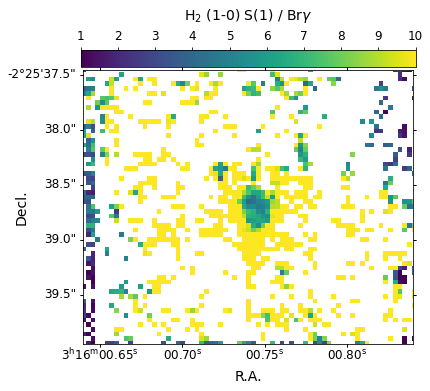

In [10]:
#ax1: H2 (1-0) S(2)/S(0)
#ax2: H2 (2-1)/(1-0) S(1) 
#ax3: H2 (1-0) S(1)/ Brgamma



fig = plt.figure(figsize=(6, 6))
gs = GridSpec(1, 1, wspace=0.1)


ax1 = fig.add_subplot(gs[0,0], projection=cube_wcs)


h2_mappable = ax1.imshow(H2_brgamma, transform=ax1.get_transform(cube_wcs), vmin=1, vmax=10)

cbar1 = fig.colorbar(h2_mappable, ax=ax1, orientation='horizontal', location='top', pad=0.01)
cbar1.ax.tick_params(labelsize=12)

ax1.tick_params(labelsize=12)
ax1.set_ylabel('Decl.', fontsize=14, labelpad=-1)
ax1.set_xlabel('R.A.', fontsize=14)
ax1.set_title(r'H$_2$ (1-0) S(1) / Br$\gamma$', fontsize=14, pad=50)

ax1.set_xlim(5,75)
ax1.set_ylim(5,63)


plt.savefig('plots/H2_brgamma_ratio.pdf', dpi=500, bbox_inches='tight')

## plot velocity maps, linewidth maps here as well

Text(0.5, 1.0, 'Component 2 line $\\sigma$ (km/s)')

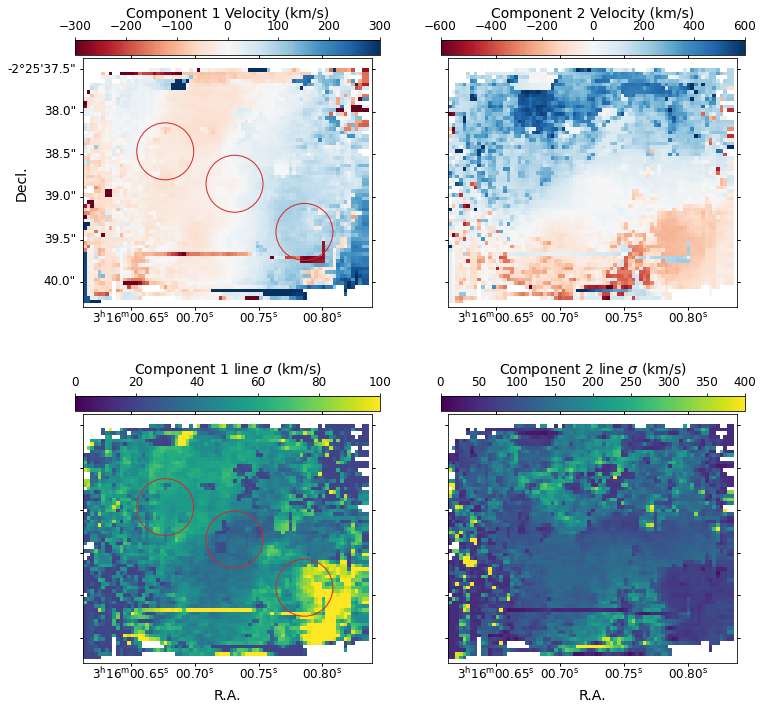

In [104]:
fig = plt.figure(figsize=(12,12))
gs = GridSpec(2, 2, wspace=0.2, hspace=0.2)

gal_cen_p = Circle(gal_cen_pix, radius=radius_pix, fill=None, edgecolor='tab:red')
ap1_cen_p = Circle(ap1_cen_pix, radius=radius_pix, fill=None, edgecolor='tab:red')
ap2_cen_p = Circle(ap2_cen_pix, radius=radius_pix, fill=None, edgecolor='tab:red')

##AX0 - velc1
ax0 = fig.add_subplot(gs[0,0], projection=cube.wcs.celestial)

v1_mappable = ax0.imshow(vel1, vmin=-300, vmax=300, cmap='RdBu')

cbar0 = fig.colorbar(v1_mappable, ax=ax0, orientation='horizontal', location='top', pad=0.01)
cbar0.ax.tick_params(labelsize=12)

ax0.tick_params(labelsize=12)
ax0.set_ylabel('Decl.', fontsize=14, labelpad=-1)
ax0.set_xlabel(' ', fontsize=14)
ax0.set_title(r'Component 1 Velocity (km/s)', fontsize=14, pad=40)

ax0.add_patch(gal_cen_p)
ax0.add_patch(ap1_cen_p)
ax0.add_patch(ap2_cen_p)

## AX1 - velc2
ax1 = fig.add_subplot(gs[0,1], projection=maps_wcs, sharex=ax0, sharey=ax0)

v2_mappable = ax1.imshow(vel2, vmin=-600, vmax=600, cmap='RdBu')

cbar1 = fig.colorbar(v2_mappable, ax=ax1, orientation='horizontal', location='top', pad=0.01)
cbar1.ax.tick_params(labelsize=12)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelleft=False)
ax1.set_ylabel(' ')
ax1.set_xlabel(' ', fontsize=14)
ax1.set_title(r'Component 2 Velocity (km/s)', fontsize=14, pad=40)

##AX2 - sigma c1
ax2 = fig.add_subplot(gs[1,0], projection=maps_wcs, sharex=ax0, sharey=ax0)

s1_mappable = ax2.imshow(sigma1, vmin=0, vmax=100)

cbar2 = fig.colorbar(s1_mappable, ax=ax2, orientation='horizontal', location='top', pad=0.01)
cbar2.ax.tick_params(labelsize=12)

ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelleft=False)
ax2.set_ylabel('Decl.', fontsize=14, labelpad=-1)
ax2.set_xlabel('R.A.', fontsize=14)
ax2.set_title(r'Component 1 line $\sigma$ (km/s)', fontsize=14, pad=40)

gal_cen_p = Circle(gal_cen_pix, radius=radius_pix, fill=None, edgecolor='tab:red')
ap1_cen_p = Circle(ap1_cen_pix, radius=radius_pix, fill=None, edgecolor='tab:red')
ap2_cen_p = Circle(ap2_cen_pix, radius=radius_pix, fill=None, edgecolor='tab:red')

ax2.add_patch(gal_cen_p)
ax2.add_patch(ap1_cen_p)
ax2.add_patch(ap2_cen_p)


##AX3 - sigma c2
ax3 = fig.add_subplot(gs[1,1], projection=maps_wcs, sharex=ax0, sharey=ax0)

s2_mappable = ax3.imshow(sigma2, vmin=0, vmax=400)

cbar3 = fig.colorbar(s2_mappable, ax=ax3, orientation='horizontal', location='top', pad=0.01)
cbar3.ax.tick_params(labelsize=12)

ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelleft=False)
ax3.set_ylabel(' ')
ax3.set_xlabel('R.A.', fontsize=14)
ax3.set_title(r'Component 2 line $\sigma$ (km/s)', fontsize=14, pad=40)

In [167]:
### pv diagrams

#path = Path(ap1_cen_pix, ap2_cen_pix) ##bug with pvextractor, pixel coordinate definition doesn't work

#extract PV diagram
path = PathFromCenter(center=gal_cen, length=3.1*u.arcsecond, angle=120*u.degree)


obs_lam = 2.1218 * u.micron * (1+z)
cube_h2_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=obs_lam)
slab_h2 = cube_h2_kms.spectral_slab(-1000*u.km/u.s, 1000*u.km/u.s)

pv = extract_pv_slice(cube=slab_h2, path=path, spacing=1)

pv_img = pv.data
pv_wcs = WCS(pv.header)

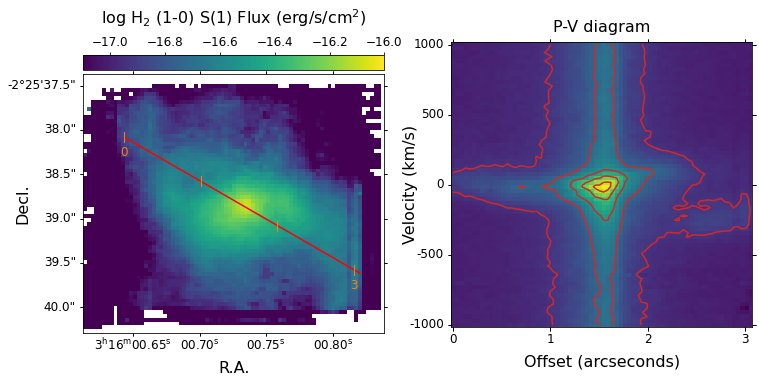

In [173]:
##plot PV diagram

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, wspace=0.22)

## AX0
ax0 = fig.add_subplot(gs[0,0], projection=maps_wcs)

log_H2_10_S1_flux_det = np.log10(H2_10_S1_flux_det)
h2_mappable = ax0.imshow(log_H2_10_S1_flux_det, vmin=-17.1, vmax=-16)

cbar0 = fig.colorbar(h2_mappable, ax=ax0, orientation='horizontal', location='top', pad=0.01)
cbar0.ax.tick_params(labelsize=12)

ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
ax0.set_ylabel('Decl.', fontsize=16, labelpad=-1)
ax0.set_xlabel('R.A.', fontsize=16)
ax0.set_title(r'log H$_2$ (1-0) S(1) Flux (erg/s/cm$^2$)', fontsize=16, pad=50)


path.show_on_axis(ax0, spacing=1, color='r')
path_length, path_x, path_y  = path.sample_points_edges(1*u.arcsecond * as_to_pix, maps_wcs)
ax0.text(path_x[0]-1, path_y[0]-5, '0', fontsize=12, color='tab:orange')
ax0.text(path_x[-1]-1, path_y[-1]-5, '3', fontsize=12, color='tab:orange')

ax0.plot(path_x, path_y, linestyle='', marker='|', color='tab:orange', markersize=10)


##AX1
ax1 = fig.add_subplot(gs[0,1], projection=pv_wcs)

cont_levels = np.max(pv_img) * np.array([0.1, 0.3, 0.5, 0.7, 0.9])
pv_mappable = ax1.imshow(pv_img)#, vmin=-17.1, vmax=-16.8)
ax1.contour(pv_img, levels=cont_levels, colors='tab:red')

#cbar1 = fig.colorbar(pv_mappable, ax=ax1, orientation='horizontal', location='top', pad=0.01)
#cbar1.ax.tick_params(labelsize=12)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1_x = ax1.coords[0]
ax1_x.set_format_unit(u.arcsecond)
ax1_x.set_major_formatter('x')
ax1_y = ax1.coords[1]
ax1_y.set_format_unit(u.km/u.s)
ax1.set_ylabel('Velocity (km/s)', fontsize=16, labelpad=-0.1)
ax1.set_xlabel('Offset (arcseconds)', fontsize=16)
ax1.set_title('P-V diagram', fontsize=16, pad=10)

pv_img.shape
#print(ax1.get_ylim())
#ax1.set_xlim(20,60)
#ax1.set_ylim(10, 55

plt.savefig('plots/H2_pv_diagram.png', dpi=300)

In [63]:
cube_head['CRPIX1'], maps_head['CRPIX1']

(66.999944, 70.999944)

In [64]:
cube_head['CRPIX2'], maps_head['CRPIX2']

(60.000178, 62.500178)

In [7]:
0.8*u.arcsecond / as_per_kpc

<Quantity 0.11963467 kpc>